In [485]:
import numpy as np
import pandas as pd

class LogisticRegression:
    def __init__(self, learning_rate=0.01, lambda_param=0):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.theta = None

    def sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def initialize(self, X, random_seed=42):
        np.random.seed(random_seed) 
        n_features = X.shape[1]
        self.theta = np.random.randn(n_features + 1) * 0.01


    def calculate_gradient_l2(self, X, y):
        m = X.shape[0]
        h = self.sigmoid(np.dot(X, self.theta))
        gradient = np.dot(X.T, (h - y)) / m
        
        # Debug prints
        print(f"lambda_param: {self.lambda_param}")
        print(f"m: {m}")
        print(f"theta[1:]: {self.theta[1:]}")
        print(f"L2 term: {(self.lambda_param / m) * self.theta[1:]}")
        
        # L2 regularization term
        gradient[1:] += (self.lambda_param / m) * self.theta[1:]
        return gradient

    def fit(self, X, y, regularized=False):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.initialize(X)
        m, n = X.shape
        X_with_bias = np.column_stack([np.ones(m), X])
        
        for i in range(m):
            x_i = X_with_bias[i]
            y_i = y[i]
            h = self.sigmoid(np.dot(self.theta, x_i))
            gradient = (h - y_i) * x_i
            if regularized:
                # L2 regularization term
                reg_term = (self.lambda_param / m) * self.theta[1:]
                gradient[1:] += reg_term
            
            self.theta -= self.learning_rate * gradient

        self.theta = np.clip(self.theta, -1e15, 1e15)

    def fit_l2(self, X, y, num_iterations=1000):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        self.initialize(X)
        m, n = X.shape
        X_with_bias = np.column_stack([np.ones(m), X])

        for _ in range(num_iterations):
            gradient = self.calculate_gradient_l2(X_with_bias, y)
            self.theta -= self.learning_rate * gradient

        print(f"Final theta: {self.theta}")

    def predict(self, X, threshold=0.5):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values

        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        prob = self.sigmoid(np.dot(X_with_bias, self.theta))
        predictions = (prob >= threshold).astype(int)
        
        return predictions

    def calculate_loss(self, X, y):
        m = X.shape[0]
        h = self.sigmoid(np.dot(X, self.theta))
        epsilon = 1e-15
        loss = -np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon)) / m
        # Add L2 regularization term to the loss
        l2_term = (self.lambda_param / (2 * m)) * np.sum(self.theta[1:]**2)
        return loss + l2_term

In [486]:
import numpy as np
from sklearn.metrics import accuracy_score


def select_lambda(X_train, y_train, X_val, y_val):
    lambda_values = [0.001, 0.01, 0.1, 1, 10, 100]

    best_lambda = None
    best_accuracy = 0
    for lambda_param in lambda_values:
        model = LogisticRegression(learning_rate=0.1, lambda_param=lambda_param)
        model.fit_l2(X_train, y_train)
        y_val_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_lambda = lambda_param

    return best_lambda

def forward_stepwise_selection(X_train, y_train, X_val, y_val, learning_rate=0.001, l2_reg=0):
    n_features = X_train.shape[1]
    selected_features = []
    remaining_features = list(X_train.columns)
    best_accuracy = 0

    while remaining_features:
        best_feature = None
        best_accuracy_improvement = 0
        
        for feature in remaining_features:
            features_to_try = selected_features + [feature]
            X_train_subset = X_train[features_to_try]
            X_val_subset = X_val[features_to_try]

            model = LogisticRegression(learning_rate=learning_rate, lambda_param=l2_reg)
            model.fit(X_train_subset, y_train)
            y_val_pred = model.predict(X_val_subset)
            accuracy = accuracy_score(y_val, y_val_pred)

            accuracy_improvement = accuracy - best_accuracy
            if accuracy_improvement > best_accuracy_improvement:
                best_accuracy_improvement = accuracy_improvement
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_accuracy += best_accuracy_improvement
            print(f"Added feature: {best_feature}. New accuracy: {best_accuracy:.4f}")
        else:
            break

    return selected_features

In [487]:
import pandas as pd
from sklearn.model_selection import train_test_split

def load_and_split_data(filepath, target_col, test_size=0.1, val_size=0.1):
    data = pd.read_csv(filepath)
    y = data[target_col]
    X = data.drop([target_col], axis=1)

    # Handle categorical variables
    if "famhist" in X.columns:
        X = pd.get_dummies(X, columns=["famhist"], drop_first=True)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

def create_multiple_splits(X, y, num_splits=10, val_size=0.2):

    X_trains, X_vals, y_trains, y_vals = [], [], [], []

    for _ in range(num_splits):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42)
        X_trains.append(X_train)
        X_vals.append(X_val)
        y_trains.append(y_train)
        y_vals.append(y_val)
        
    return X_trains, X_vals, y_trains, y_vals

In [488]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scatterplot_matrix(data, target_col):

    # variable = ["sbp", "tobacco", "ldl", "famhist", "obesity", "alcohol", "age"]
    # Handle categorical variables
    if "famhist" in data.columns:
        data_encoded = pd.get_dummies(data, columns=["famhist"], drop_first=True)

    plt.figure(figsize=(20, 20))
    g = sns.PairGrid(data_encoded, hue=target_col)
    g.map_diag(sns.histplot, hue=None, color=".3")
    g.map_offdiag(sns.scatterplot)

    plt.suptitle(
        "Figure 4.12: Scatterplot Matrix of South African Heart Disease Data", y=1.02
    )
    plt.tight_layout()
    plt.show()

In [495]:
# Parameters
DATASET_PATH = "data/south_african_heart_disease.csv"
TARGET_COLUMN = "chd"
TEST_SIZE = 0.1
VAL_SIZE = 0.1
LEARNING_RATE = 0.001  

<Figure size 2000x2000 with 0 Axes>

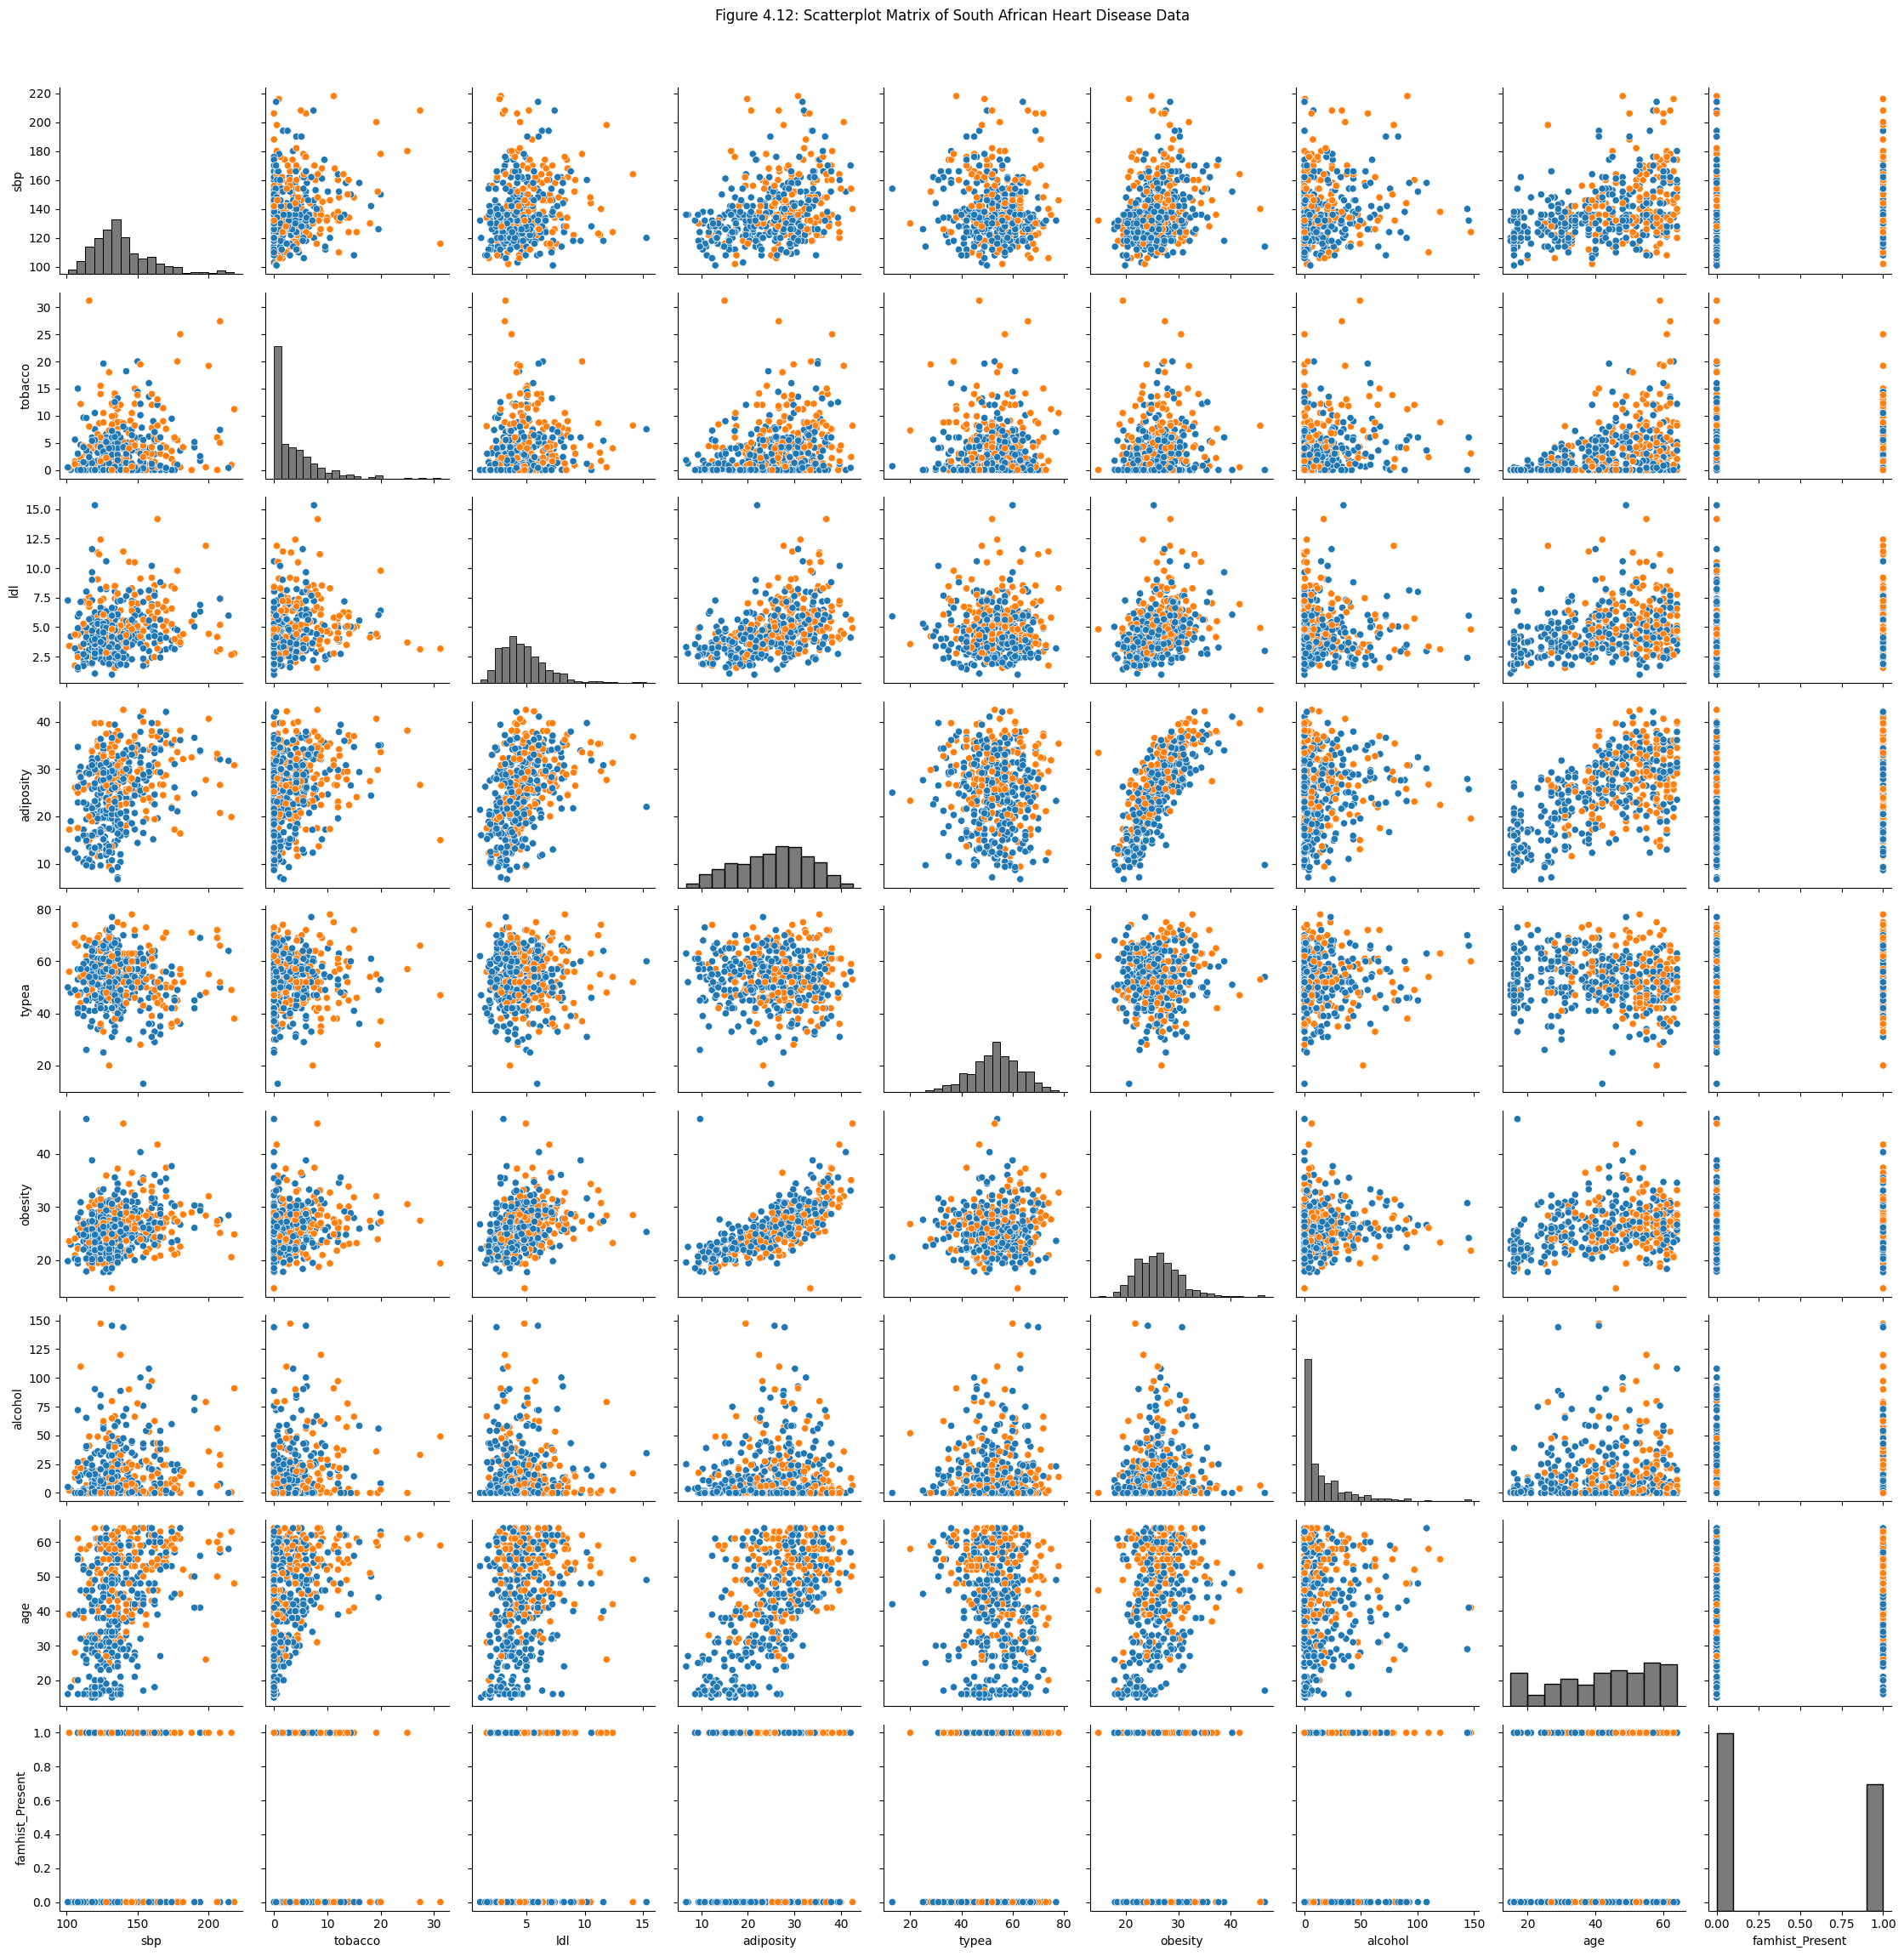

In [490]:
from sklearn.preprocessing import StandardScaler

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(
    DATASET_PATH, TARGET_COLUMN, TEST_SIZE, VAL_SIZE
)

data = pd.read_csv(DATASET_PATH)
target_col = "chd"

plot_scatterplot_matrix(data, target_col)

# Preprocess the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [491]:
from sklearn.metrics import accuracy_score

unregularized_model = LogisticRegression(learning_rate=LEARNING_RATE)
unregularized_model.fit(X_train_scaled, y_train)
y_pred_test = unregularized_model.predict(X_test_scaled)
unregularized_accuracy = accuracy_score(y_test, y_pred_test)

In [492]:
# Prepare the data
step_data = pd.read_csv(DATASET_PATH)
step_y = step_data[TARGET_COLUMN]
step_X = step_data.drop([TARGET_COLUMN], axis=1)

if "famhist" in step_X.columns:
    step_X = pd.get_dummies(step_X, columns=["famhist"], drop_first=True)

scaler = StandardScaler()
step_X_scaled = pd.DataFrame(scaler.fit_transform(step_X), columns=step_X.columns)

# Create multiple splits
step_X_trains, step_X_vals, step_y_trains, step_y_vals = create_multiple_splits(step_X_scaled, step_y, num_splits=10)

# Perform stepwise feature selection
selected_features = forward_stepwise_selection(step_X_trains[0], step_y_trains[0], step_X_vals[0], step_y_vals[0], learning_rate=0.001)

stepwise_model = LogisticRegression(learning_rate=LEARNING_RATE)
stepwise_model.fit(step_X_scaled[selected_features], step_y)

# Evaluate on a held-out test set
step_X_train, step_X_test, step_y_train, step_y_test = train_test_split(step_X_scaled, step_y, test_size=0.2, random_state=42)
step_y_pred_test = stepwise_model.predict(step_X_test[selected_features])
stepwise_accuracy = accuracy_score(step_y_test, step_y_pred_test)

print(f"Stepwise Model Accuracy: {stepwise_accuracy:.4f}")
print("Selected features:", selected_features)

Added feature: tobacco. New accuracy: 0.7312
Stepwise Model Accuracy: 0.7419
Selected features: ['tobacco']


In [493]:
best_lambda = select_lambda(X_train_scaled, y_train, X_val_scaled, y_val)
l2_model = LogisticRegression(learning_rate=LEARNING_RATE, lambda_param=best_lambda)
l2_model.fit_l2(X_train_scaled, y_train)
l2_y_pred_test = l2_model.predict(X_test_scaled)
l2_accuracy = accuracy_score(y_test, l2_y_pred_test)

lambda_param: 0.001
m: 369
theta[1:]: [-0.00138264  0.00647689  0.0152303  -0.00234153 -0.00234137  0.01579213
  0.00767435 -0.00469474  0.0054256 ]
L2 term: [-3.74700003e-09  1.75525349e-08  4.12745219e-08 -6.34561991e-09
 -6.34517499e-09  4.27970953e-08  2.07976891e-08 -1.27228831e-08
  1.47035242e-08]
lambda_param: 0.001
m: 369
theta[1:]: [0.00809775 0.0190093  0.02663538 0.00923854 0.00224231 0.01904538
 0.01037865 0.0130358  0.01715687]
L2 term: [2.19451190e-08 5.15157250e-08 7.21826032e-08 2.50366972e-08
 6.07671522e-09 5.16134997e-08 2.81264277e-08 3.53273587e-08
 4.64955708e-08]
lambda_param: 0.001
m: 369
theta[1:]: [0.0169279  0.03080574 0.03733201 0.01984604 0.00676665 0.02166707
 0.01285072 0.02974296 0.02830277]
L2 term: [4.58750788e-08 8.34843798e-08 1.01170771e-07 5.37833076e-08
 1.83378083e-08 5.87183587e-08 3.48258054e-08 8.06042355e-08
 7.67012814e-08]
lambda_param: 0.001
m: 369
theta[1:]: [0.02515561 0.04191617 0.04737203 0.02955769 0.01123102 0.02371333
 0.01510812 0

In [494]:
print("\nModel Comparison:")
print("Model\t\t\tAccuracy")
print("---------------------------------")
print(f"Unregularized\t\t{unregularized_accuracy:.4f}")
print(f"Stepwise\t\t{stepwise_accuracy:.4f}")
print(f"L2 Regularized\t\t{l2_accuracy:.4f}")


Model Comparison:
Model			Accuracy
---------------------------------
Unregularized		0.7447
Stepwise		0.7419
L2 Regularized		0.7872
